In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from cemba_data.tools.integration.utilities import calculate_direct_confusion
from ALLCools.plot import *
from ALLCools.plot.color import plot_colorbar
import xarray as xr

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

In [6]:
cell_tidy_data = cell_tidy_data[cell_tidy_data['CellClass'] == 'Exc'].copy()

In [9]:
cell_tidy_data.columns

Index(['AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate',
       'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region',
       'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96',
       'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice',
       'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1',
       'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1',
       'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1',
       'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0',
       'class_umap_1', 'Order', 'RegionName', 'MajorRegion', 'SubRegion',
       'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)',
       'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor',
       'DissectionRegionColor', 'Replicate'],
      dtype='object')

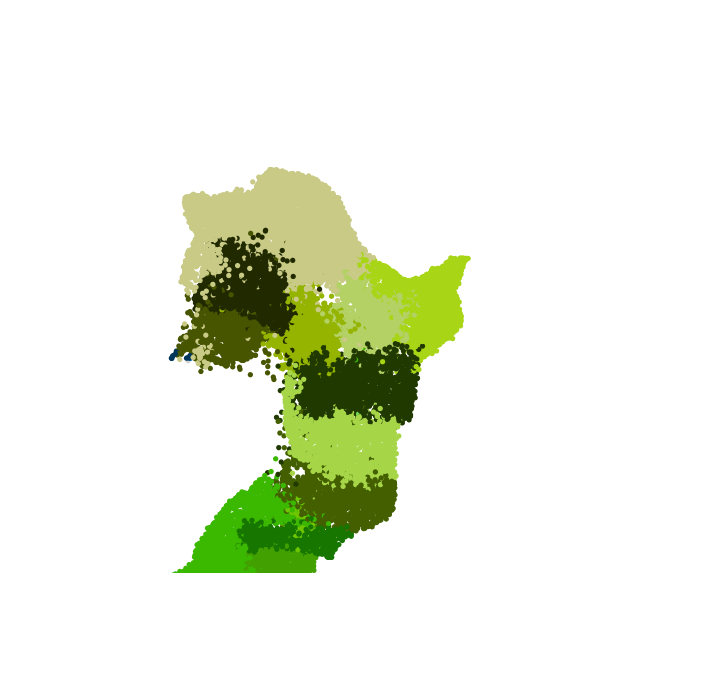

In [48]:
fig, ax = plt.subplots(figsize=(0.5, 0.5), dpi=1200)

categorical_scatter(ax=ax,
                    data=cell_tidy_data,
                    coord_base='class_umap',
                    hue='SubType',
                    palette=sub_type_palette,
                    s=0.1,
                    max_points=None,
                    axis_format=None,
                    # text_anno='MajorType', 
                    # text_anno_kws=dict(fontsize=0.5)
                   )
ax.set(xlim=(2, 23), ylim=(-19, 2))
# add_ax_box(ax, linewidth=0.1)
pass

In [27]:
mcds = xr.open_mfdataset(
    '/home/hanliu/project/mouse_rostral_brain/study/Level1-CellClass/ALL_manual/Adata/Select*mcds'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [28]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    index_col='gene_id',
    sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].iteritems()}
gene_idbase_to_id = {i.split('.')[0]: i for i in gene_meta.index}

In [31]:
def add_gene_data(gene):
    if gene not in cell_tidy_data.columns:
        gene_id = gene_name_to_id[gene]
        gene_data = mcds.sel(gene=gene_id, cell=cell_tidy_data.index, mc_type='CHN')['gene_da'].to_pandas()
        cell_tidy_data[gene] = gene_data

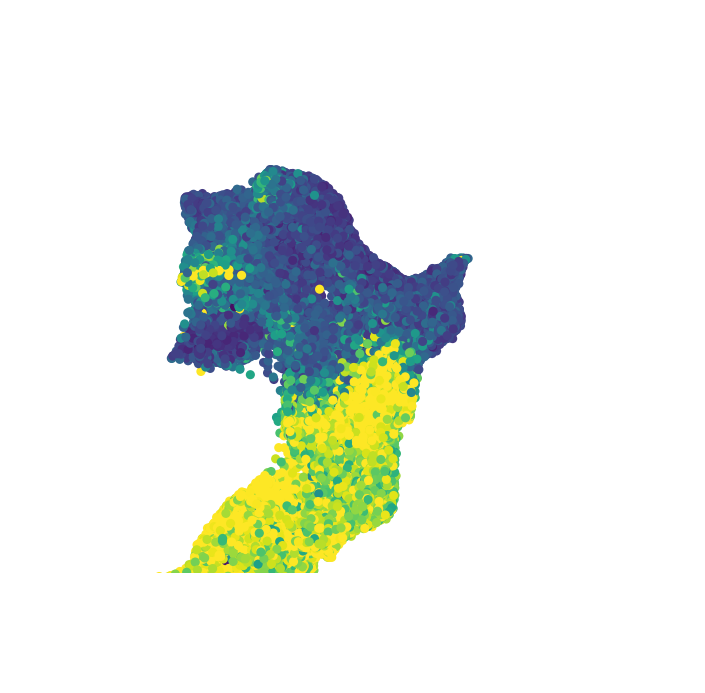

In [51]:
gene = 'Cux2'
add_gene_data(gene=gene)

fig, ax = plt.subplots(figsize=(0.5, 0.5), dpi=1200)

continuous_scatter(ax=ax,
                   data=cell_tidy_data,
                   coord_base='class_umap',
                   hue=gene,
                   hue_norm=(0, 2),
                   s=0.3,
                   max_points=None,
                   # text_anno='SubType', 
                   axis_format=None,
                   text_anno_kws=dict(fontsize=2), colorbar=False)

# EP, CLA
# ax.set(xlim=(-6, 12), ylim=(-27, -9))
# IT 
ax.set(xlim=(2, 23), ylim=(-19, 2))

# add_ax_box(ax, linewidth=0.1)
pass
fig.savefig(f'{gene}.zoom_in.png')

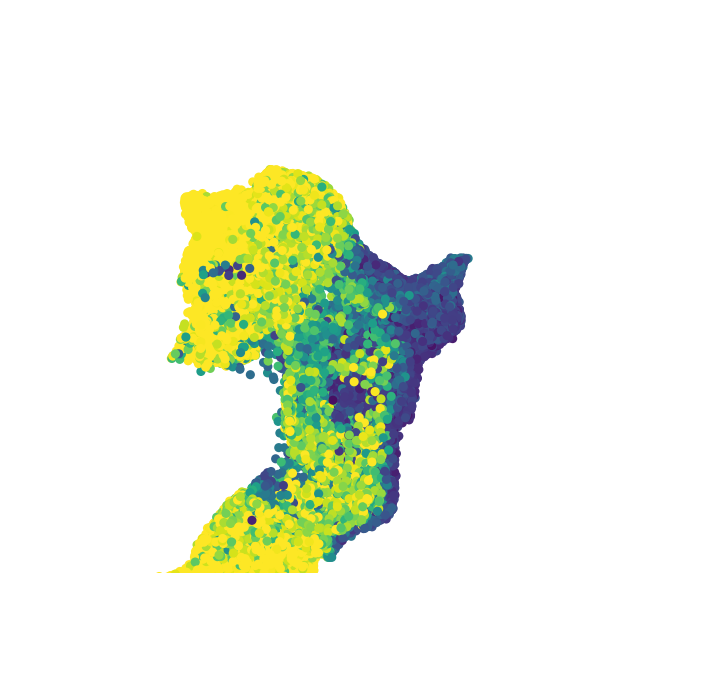

In [52]:
gene = 'Rorb'
add_gene_data(gene=gene)

fig, ax = plt.subplots(figsize=(0.5, 0.5), dpi=1200)

continuous_scatter(ax=ax,
                   data=cell_tidy_data,
                   coord_base='class_umap',
                   hue=gene,
                   hue_norm=(0, 2),
                   s=0.3,
                   max_points=None,
                   # text_anno='SubType', 
                   axis_format=None,
                   text_anno_kws=dict(fontsize=2), colorbar=False)

# EP, CLA
# ax.set(xlim=(-6, 12), ylim=(-27, -9))
# IT 
ax.set(xlim=(2, 23), ylim=(-19, 2))

# add_ax_box(ax, linewidth=0.1)
pass
fig.savefig(f'{gene}.zoom_in.png')

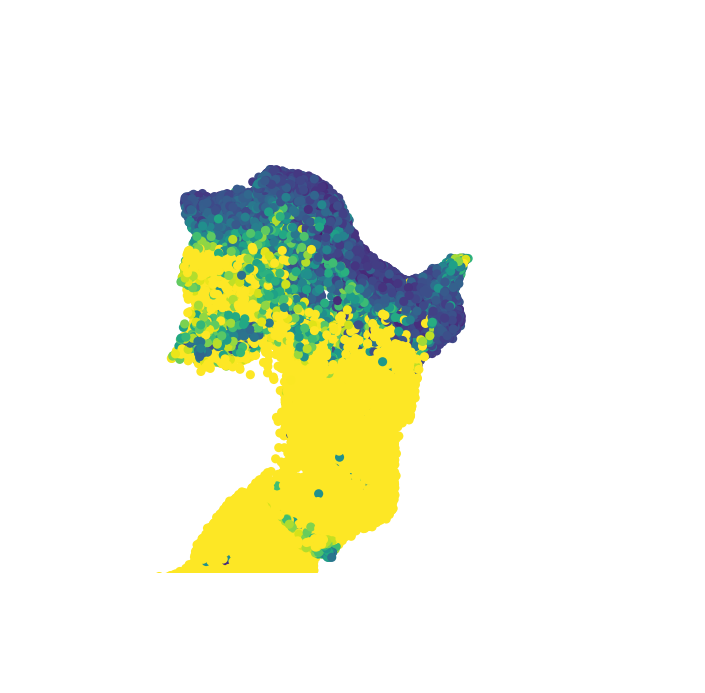

In [53]:
gene = 'Cux1'
add_gene_data(gene=gene)

fig, ax = plt.subplots(figsize=(0.5, 0.5), dpi=1200)

continuous_scatter(ax=ax,
                   data=cell_tidy_data,
                   coord_base='class_umap',
                   hue=gene,
                   hue_norm=(0, 2),
                   s=0.3,
                   max_points=None,
                   # text_anno='SubType', 
                   axis_format=None,
                   text_anno_kws=dict(fontsize=2), colorbar=False)

# EP, CLA
# ax.set(xlim=(-6, 12), ylim=(-27, -9))
# IT 
ax.set(xlim=(2, 23), ylim=(-19, 2))

# add_ax_box(ax, linewidth=0.1)
pass
fig.savefig(f'{gene}.zoom_in.png')

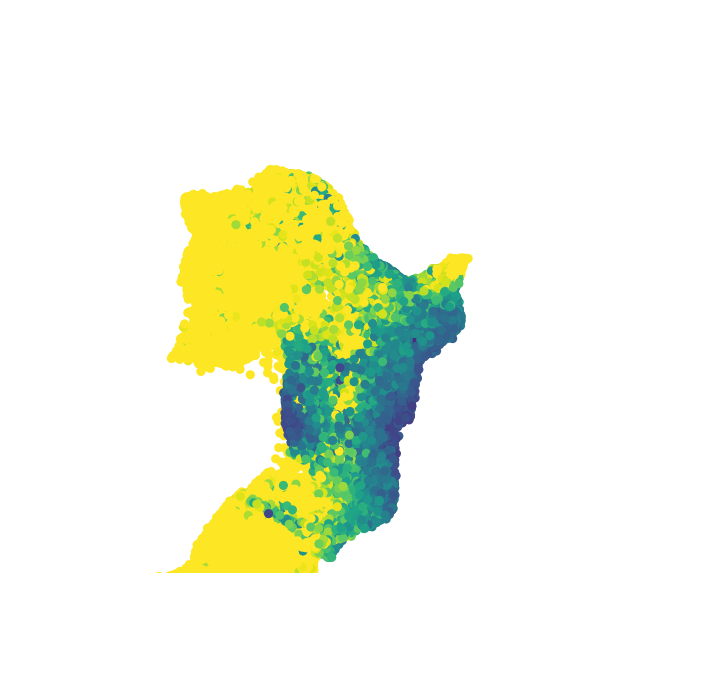

In [54]:
gene = 'Rora'
add_gene_data(gene=gene)

fig, ax = plt.subplots(figsize=(0.5, 0.5), dpi=1200)

continuous_scatter(ax=ax,
                   data=cell_tidy_data,
                   coord_base='class_umap',
                   hue=gene,
                   hue_norm=(0, 2),
                   s=0.3,
                   max_points=None,
                   # text_anno='SubType', 
                   axis_format=None,
                   text_anno_kws=dict(fontsize=2), colorbar=False)

# EP, CLA
# ax.set(xlim=(-6, 12), ylim=(-27, -9))
# IT 
ax.set(xlim=(2, 23), ylim=(-19, 2))

# add_ax_box(ax, linewidth=0.1)
pass
fig.savefig(f'{gene}.zoom_in.png')